In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm import *
import torch
import random
from pathlib import Path
from config import *
from load_utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm'

In [4]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_lstm_sl_16
num selection:1 - exp name:4_wheel_system_lstm_forecast_sl_30_run_2
num selection:2 - exp name:third_wheel_lstm_forecast_sl_16_run_1


In [5]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_lstm_sl_16


In [6]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm/4_wheel_system_lstm_sl_16/summary.csv


In [15]:
summary.drop(columns = ['train_loss']).reset_index().head()

,index,Unnamed: 0,name,parameters_number,val_loss
0,39,0,"trainLSTM_7ca9d_00037_37_batch_size=100,embedd...",8132,0.074152
1,38,21,"trainLSTM_7ca9d_00010_10_batch_size=500,embedd...",8132,0.074266
2,37,26,"trainLSTM_7ca9d_00021_21_batch_size=100,embedd...",8132,0.074666
3,36,33,"trainLSTM_7ca9d_00007_7_batch_size=100,embeddi...",30596,0.074702
4,35,30,"trainLSTM_7ca9d_00001_1_batch_size=500,embeddi...",12404,0.074763


In [16]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 100, 'embedding_dim': 16, 'epochs': 200, 'lr': 0.001, 'lr_patience': 10, 'n_layers_cell_1': 1, 'n_layers_cell_2': 2, 'seq_in_length': 16}


In [17]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [18]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [19]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [20]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 160
random shift 96409


In [21]:
inject_anomalies = False
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))

x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                     sequence_length=params_conf['sequence_length'], cols=cfg.dataset.columns
                             , shift = None)

time horizon 160
random shift 106657


In [22]:
model = LSTM(seq_in=params_conf['sequence_length'], seq_out= params_conf['out_window']
              , n_features=params_conf['n_features'],
            output_size=params_conf["output_size"], embedding_dim=params_conf['embedding_dim'],
            n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Encoder(
  (LSTMenc): LSTM(4, 32, batch_first=True)
  (LSTM1): LSTM(32, 16, batch_first=True)
  (out): Linear(in_features=16, out_features=4, bias=True)
)
number of params 8132


In [23]:
yo = model(x.to(device))

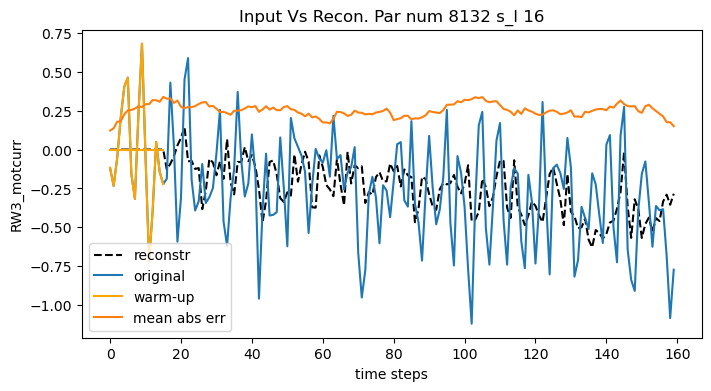

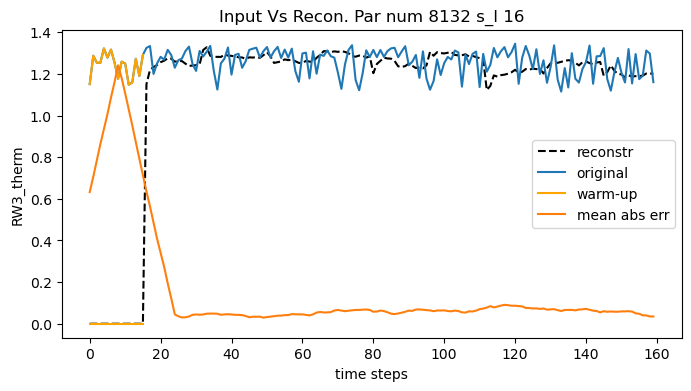

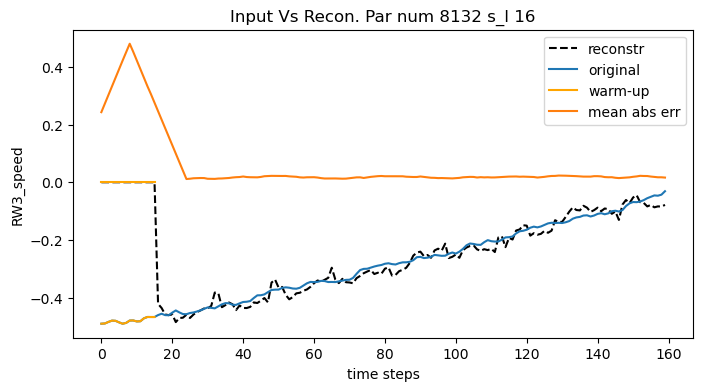

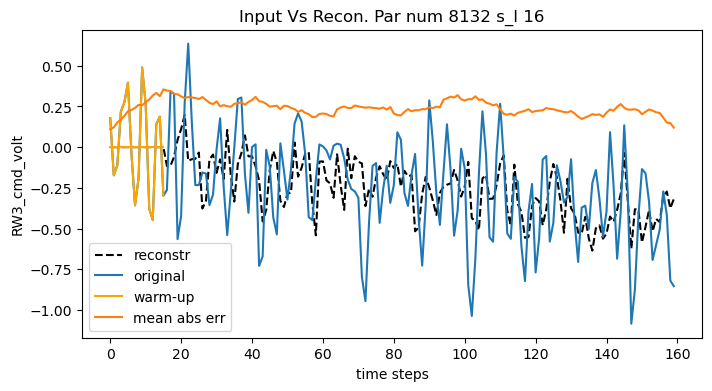

In [24]:
show_results(x.to(device),yo,cfg.dataset.columns,
    model_name,params_conf,par_nums,shift,
    num_batch,architecture='lstm',
    save=False)